In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku 
import numpy as np 
import pandas as pd

Definition of a plot function for training result visualization

In [ ]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    
    plt.show()

## Data preproccesing

We load a txt file containing Shakespeare sonnets

In [ ]:
data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

In [ ]:
corpus[0:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

We need to transform each text sentence into token sequence.

Then we need to generate from each token sequence, several token subsequences in order to augment the dataset. **Remember** that we want to learn how to predict the next word of a sentence. A sentence of 5 words can so be used to generate 4 training sequences.

e.g. the sentence "*to be or not to be*" can give the following training sequences: 

"*to* **be**"

"*to be* **or**"

"*to be or* **not**"

"*to be or not* **to**"

"*to be or not to* **be**"

In [ ]:
tokenizer = Tokenizer()

# Question 1: use the preprocessing steps learned in course3_text_sequence_preprocessing_ex.ipynb to create the padded sequences needed to train the model
# Hint: Be careful about the length you will use for the padding sequences AND about where you put the extra zero coming from the padding (at the beginning of the sequence or at the end)

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

sequences = []
for i in corpus:
	token_list = tokenizer.texts_to_sequences([i])[0]
	for j in range(len(token_list)):
		token_sequence = token_list[:j+1]
		sequences.append(token_sequence)


# padding
input_sequences = np.array(pad_sequences(sequences, padding='pre',maxlen=max([len(x) for x in sequences])))
X = input_sequences[:,:-1],
y_before = input_sequences[:,-1]
print("featurs :",X)
print("target :",y_before)

y = ku.to_categorical(y_before, num_classes=total_words)
print(y)

featurs : (array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,   34],
       [   0,    0,    0, ...,    0,   34,  417],
       ...,
       [   0,    0,    0, ..., 3209,  493,  493],
       [   0,    0,    0, ...,  493,  493, 3210],
       [   0,    0,    0, ...,  493, 3210,   15]], dtype=int32),)
target : [  34  417  877 ... 3210   15   14]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Neural network model definition

Build a neural network using at least one LSTM layer

(you may have a look at https://keras.io/api/layers/)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Question 2: define a neural network model using at least one LSTM layer
# Hint1: we advise you to use as first layer an Embedding layer (have a look at course3_sentiment_analysis_LSTM_ex.ipynb for a reminder of how to use it)
# Hint2: you can import any additional layers from tensorflow.keras.layers if needed

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max([len(x) for x in sequences])-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words,activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))



# Question 3: define a relevant loss function and optimizer

loss_function = "categorical_crossentropy" #"binary_crossentropy"
optimizer = "adam"

model.compile(loss=loss_function, optimizer=optimizer,metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 3211)              324311    
_________________________________________________________________
dense_1 (Dense)              (None, 1605)              5155260   
_________________________________________________________________
dense_2 (Dense)              (None, 3211)              5

In [ ]:
# Question 4: train your model with relevant parameters

predictors = X
label = y
epochs_value = 100
validation_split_value = 0.4

history = model.fit(predictors, label, epochs=epochs_value, verbose=1, validation_split=validation_split_value)

Epoch 1/100
331/331 [==============================] - 75s 211ms/step - loss: 7.4822 - accuracy: 0.0253 - val_loss: 6.7055 - val_accuracy: 0.0275
Epoch 2/100
331/331 [==============================] - 68s 207ms/step - loss: 6.3494 - accuracy: 0.0269 - val_loss: 6.7776 - val_accuracy: 0.0285
Epoch 3/100
331/331 [==============================] - 68s 207ms/step - loss: 6.2555 - accuracy: 0.0285 - val_loss: 6.8788 - val_accuracy: 0.0301
Epoch 4/100
331/331 [==============================] - 69s 207ms/step - loss: 6.1719 - accuracy: 0.0334 - val_loss: 6.9488 - val_accuracy: 0.0332
Epoch 5/100
331/331 [==============================] - 68s 206ms/step - loss: 6.0673 - accuracy: 0.0377 - val_loss: 7.0235 - val_accuracy: 0.0348
Epoch 6/100
331/331 [==============================] - 68s 206ms/step - loss: 5.9906 - accuracy: 0.0393 - val_loss: 7.2098 - val_accuracy: 0.0350
Epoch 7/100
331/331 [==============================] - 69s 210ms/step - loss: 5.9238 - accuracy: 0.0436 - val_loss: 7.2191 -

## Result visualization

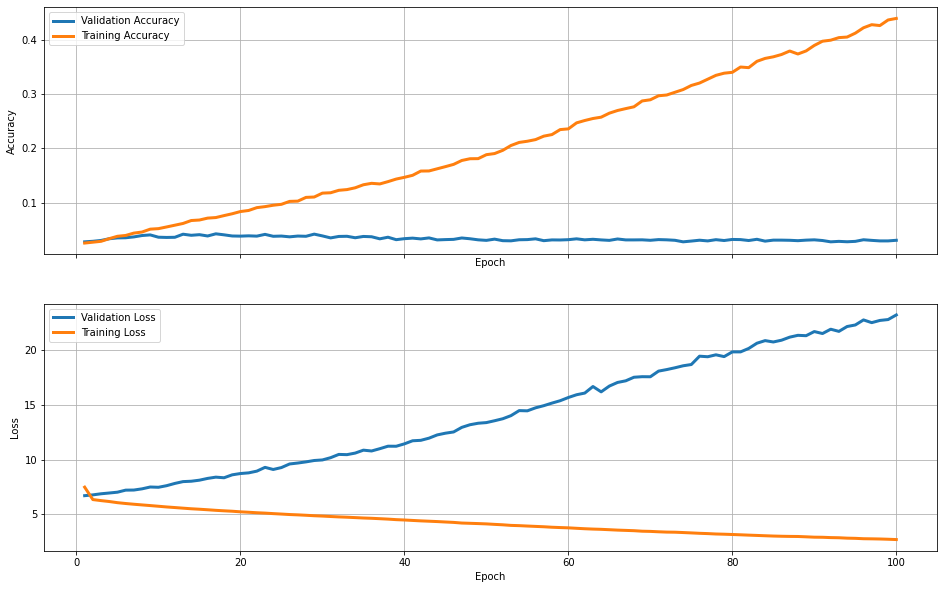

In [ ]:
plot_results(history)

## Text generation

You can now use your model to sequentially generate new words from a given uncomplete sentence

In [ ]:
seed_text = "put here the of a of your own days brow this make make every make"
nb_additional_words = 100


# Question 5: generate nb_additional_words at the end of seed_text according to your trained model

for i in range(nb_additional_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max([len(x) for x in sequences])-1, padding='pre')
  predicted = model.predict_classes(token_list, verbose=0)
  output = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output = word
      break
  seed_text += " " + output
print(seed_text)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


put here the of a of your own days brow this make make every make every husband with desert his brood effect more gems rare mother sadly few lies delight more offence truth hath inconstant weeds held appear sea to first you sea and store he ill respect we see we see men's befits still of earth unless writ be removed my verse of held mother appear appear appear appear strange enrich a plea remembrance be measured no powerful thought should die check'd eye's slow slow go bright praise lies gazeth born more kind written star this deeds in youth full eye's audit in love's sovereign appear gone the world alone new another use thyself
